In [22]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
import time

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # all output p


In [23]:
device = "mps" if torch.backends.mps.is_available() else "cpu"

# # Load the model and tokenizer
model_name = "EleutherAI/pythia-70m"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, device_map=device)

In [24]:
# tokenize prompt
tokenizer.pad_token_id = tokenizer.eos_token_id
inputs = tokenizer("What is AI?", return_tensors="pt",padding=True, truncation=True,max_length=100)

In [25]:
# generation
outputs = model.generate(**inputs.to(device))
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


What is AI?

What is the nearest to -1/2 in -1, -0.5,


Prepare dataset

In [26]:
# create a question and answer set in a list with dictionary

from datasets import Dataset

QA_list = []

with open ('QA.txt') as doc:
    Q_counter = 0
    for line in doc:
        if 'Question' in line:
            Q_dict = {'question':line.replace('Question:"',"").strip().strip('"'),'answer':''}
            QA_list.append(Q_dict)
            Q_counter+=1
        elif 'Answer' in line:
            A_counter = Q_counter-1
            modified_line = line.replace('Answer:"',"").strip().strip('"')
            QA_list[A_counter]['answer'] = modified_line
        else:
            pass

dataset = Dataset.from_list(QA_list)

In [27]:
# check dataset
dataset

Dataset({
    features: ['question', 'answer'],
    num_rows: 77
})

Tokenize as question answer pair which will be used for training

In [28]:
def tokenize_function(examples):
    text = examples["question"] + examples["answer"]


    tokenizer.pad_token = tokenizer.eos_token
    tokenized_inputs = tokenizer(
        text,
        return_tensors="pt",
        padding=True,
    )

    max_length = min(
        tokenized_inputs["input_ids"].shape[1],
        256
    )
    tokenizer.truncation_side = "left"
    tokenized_inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        max_length=max_length
    )

    return tokenized_inputs

In [29]:
tokenized_dataset = dataset.map(
    tokenize_function,
    batched=False,
    # batch_size=1,
    # drop_last_batch=True
)

print(tokenized_dataset)

Map: 100%|██████████| 77/77 [00:00<00:00, 2504.16 examples/s]

Dataset({
    features: ['question', 'answer', 'input_ids', 'attention_mask'],
    num_rows: 77
})


In [30]:
tokenized_dataset[0]

{'question': 'What are the two properties of good communication?',
 'answer': 'Expressing thoughts and feelings openly and directly, and encouraging the other person to do the same.',
 'input_ids': [[1276,
   403,
   253,
   767,
   3607,
   273,
   1175,
   5511,
   32,
   5892,
   13537,
   7906,
   285,
   10450,
   22134,
   285,
   3587,
   13,
   285,
   18462,
   253,
   643,
   1436,
   281,
   513,
   253,
   1072,
   15]],
 'attention_mask': [[1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1]]}

In [31]:
tokenized_dataset = tokenized_dataset.add_column("labels", tokenized_dataset["input_ids"])

Prepare train test split

In [32]:
split_dataset = tokenized_dataset.train_test_split(test_size=0.1, shuffle=True, seed=123)
print(split_dataset)

DatasetDict({
    train: Dataset({
        features: ['question', 'answer', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 69
    })
    test: Dataset({
        features: ['question', 'answer', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 8
    })
})


In [33]:
def inference(text, model, tokenizer, max_input_tokens=512, max_output_tokens=100):
  # Tokenize
  input_ids = tokenizer.encode(
          text,
          return_tensors="pt",
          truncation=True,
          max_length=max_input_tokens
  )

  # Generate
#   device = model.device
  device = "mps" if torch.backends.mps.is_available() else "cpu"
  generated_tokens_with_prompt = model.generate(
    input_ids=input_ids.to(device),
    max_length=max_output_tokens
  )

  # Decode
  generated_text_with_prompt = tokenizer.batch_decode(generated_tokens_with_prompt, skip_special_tokens=True)

  # Strip the prompt
  generated_text_answer = generated_text_with_prompt[0][len(text):]

  return generated_text_answer

In [34]:
test_text = split_dataset['test'][0]['question']
print("Question input (test):", test_text)
print(f"Correct answer from Lamini docs: {split_dataset['test'][0]['answer']}")
print("Model's answer: ")
print(inference(test_text, model, tokenizer))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Question input (test): What is the national bird of the United States?
Correct answer from Lamini docs: Please let's keep our discussion related to good or bad communication.
Model's answer: 


The bird is a species of bird that is found in the United States. It is found in the United States, and is found in the United States.

The bird is a species of bird that is found in the United States. It is found in the United States.

The bird is a species of bird that is found in the United States. It is found in the United States.

The bird is a species


In [ ]:
training_config = {
    "model": {
        "pretrained_name": model_name,
        "max_length" : 2048
    },
    "datasets": {
        "use_hf": use_hf,
        "path": dataset_path
    },
    "verbose": True
}

In [21]:
model_flops = (
  model.floating_point_ops(
    {
       "input_ids": torch.zeros(
           (1,2048)
      )
    }
  )
  * training_args.gradient_accumulation_steps
)

print(model)
print("Memory footprint", model.get_memory_footprint() / 1e9, "GB")
print("Flops", model_flops / 1e9, "GFLOPs")

GPTNeoXForCausalLM(
  (gpt_neox): GPTNeoXModel(
    (embed_in): Embedding(50304, 512)
    (emb_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-5): 6 x GPTNeoXLayer(
        (input_layernorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (post_attention_layernorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (post_attention_dropout): Dropout(p=0.0, inplace=False)
        (post_mlp_dropout): Dropout(p=0.0, inplace=False)
        (attention): GPTNeoXAttention(
          (query_key_value): Linear(in_features=512, out_features=1536, bias=True)
          (dense): Linear(in_features=512, out_features=512, bias=True)
        )
        (mlp): GPTNeoXMLP(
          (dense_h_to_4h): Linear(in_features=512, out_features=2048, bias=True)
          (dense_4h_to_h): Linear(in_features=2048, out_features=512, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (final_layer_norm): LayerNorm((512,), eps=1e-05, elementwise

In [15]:
training_args.gradient_accumulation_steps

2

Fine Tune

In [ ]:
from transformers import TrainingArguments, Trainer

# Define training arguments
training_args = TrainingArguments(
    output_dir="./llm_finetuned",  # Save model output here
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=2,  # Reduce if GPU memory is low
    per_device_eval_batch_size=2,
    num_train_epochs=3,  # Adjust as needed
    logging_dir="./logs",
    logging_steps=10,
    save_total_limit=2,
    fp16=True,  # Use mixed precision (faster training on GPUs)
    push_to_hub=False  # Set to True if you want to upload the model to Hugging Face Hub
)

# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
)

# Train the model
trainer.train()

In [ ]:
dataset

In [76]:
# model.config.torch_dtype = torch.float32

In [35]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(

  # Learning rate
  learning_rate=1.0e-5,

  # Number of training epochs
  num_train_epochs=1,

  # Max steps to train for (each step is a batch of data)
  # Overrides num_train_epochs, if not -1
  max_steps=15,

  # Batch size for training
  per_device_train_batch_size=1,

  # Directory to save model checkpoints
  output_dir='./fine_tuned_pythia',

  # Other arguments
  overwrite_output_dir=False, # Overwrite the content of the output directory
  disable_tqdm=False, # Disable progress bars
  eval_steps=10, # Number of update steps between two evaluations
  save_steps=10, # After # steps model is saved
  warmup_steps=1, # Number of warmup steps for learning rate scheduler
  per_device_eval_batch_size=1, # Batch size for evaluation
  eval_strategy="steps",
  logging_strategy="steps",
  # fp16=False,
  logging_steps=2,
  optim="adafactor",
  gradient_accumulation_steps = 1,
  gradient_checkpointing=False,

  # Parameters for early stopping
  load_best_model_at_end=True,
  save_total_limit=1,
  metric_for_best_model="eval_loss",
  greater_is_better=False
)

In [36]:
# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=split_dataset["train"],
    eval_dataset=split_dataset["test"],
)

# Train the model
trainer.train()

Step,Training Loss,Validation Loss


: 

/Users/abhinav/miniconda3/envs/trainllm/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


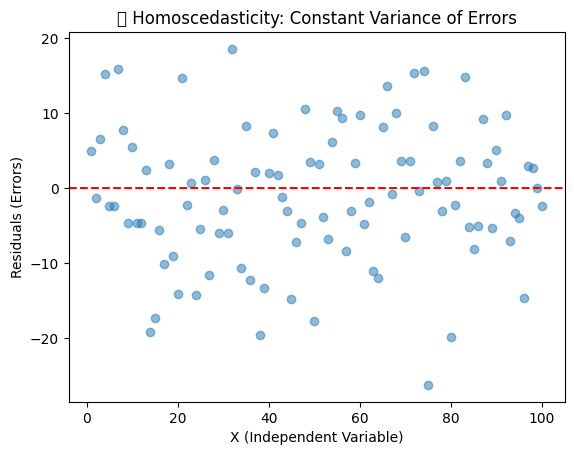

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)
X = np.linspace(1, 100, 100)
y = 2 * X + np.random.normal(0, 10, 100)  # Constant variance

plt.scatter(X, y - (2 * X), alpha=0.5)  # Residuals
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("X (Independent Variable)")
plt.ylabel("Residuals (Errors)")
plt.title("✅ Homoscedasticity: Constant Variance of Errors")
plt.show()


/Users/abhinav/miniconda3/envs/trainllm/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128680 (\N{POLICE CARS REVOLVING LIGHT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


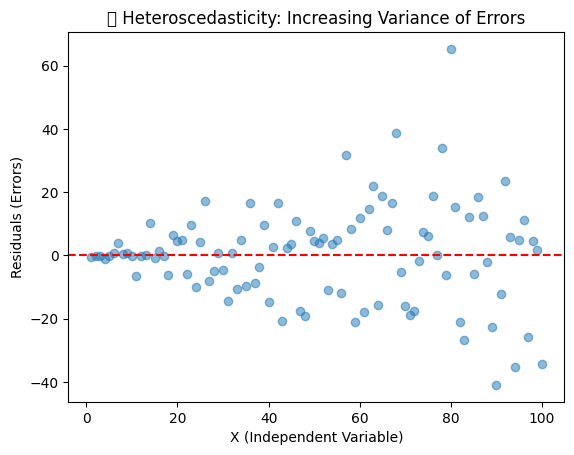

In [2]:
y_hetero = 2 * X + np.random.normal(0, X * 0.3, 100)  # Increasing variance

plt.scatter(X, y_hetero - (2 * X), alpha=0.5)  # Residuals
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("X (Independent Variable)")
plt.ylabel("Residuals (Errors)")
plt.title("🚨 Heteroscedasticity: Increasing Variance of Errors")
plt.show()


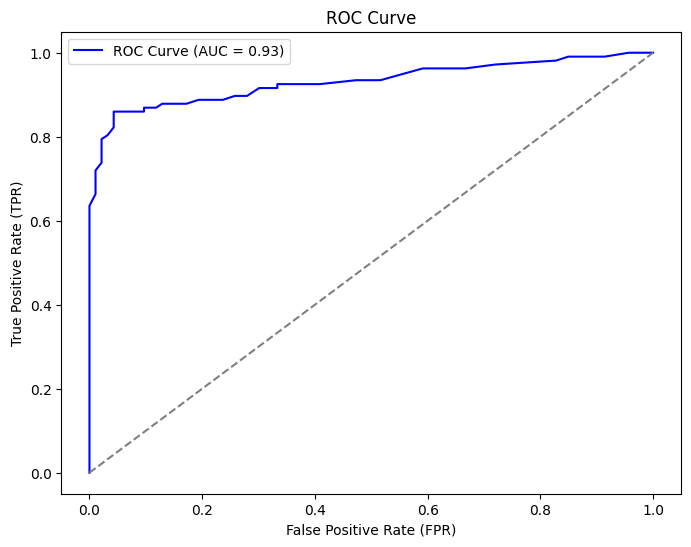

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

# Generate a binary classification dataset
X, y = make_classification(n_samples=1000, n_classes=2, random_state=42)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a classifier
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

# Get predicted probabilities
y_probs = clf.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Plot the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Random guess line
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend()
plt.show()
